# Обучение с учителем: качество модели

<a id='task'></a>
## Постановка задачи

**Тема проекта:** разработка решения для интернет-магазина, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Назначение

**Цель проекта:** 
- Промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
- Собрать данные по клиентам по следующим группам:
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
- Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

### Структура проекта
1. [Постановка задачи][1]
    1. Назначение
    2. Структура проекта
    3. Описание данных
2. [Загрузка данных][2]
3. [Предобработка данных][3]
4. [Исследовательский анализ данных][4]
    1. [Исследовательский анализ `user_behavior`][4.1]
    2. [Исследовательский анализ `user_revenue`][4.2]
    3. [Исследовательский анализ `user_time`][4.3]
    4. [Исследовательский анализ `profit`][4.4]
5. [Объединение таблиц][5]
6. [Корреляционный анализ][6]
7. [Использование пайплайнов][7]
8. [Анализ важности признаков][8]
9. [Сегментация покупателей][9]
10. [Общие выводы][10]

[1]:#task
[2]:#general
[3]:#preprocess
[4]:#research
[4.1]:#res_ub
[4.2]:#res_ur
[4.3]:#res_ut
[4.4]:#res_pr
[5]:#join
[6]:#corr
[7]:#pipe
[8]:#shap
[9]:#seg
[10]:#fin

### Описание данных

Данные для работы находятся в нескольких таблицах: `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`.

**Таблица `market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.**

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**Таблица `market_money.csv` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.**

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, `текущий_месяц` или `предыдущий_месяц`.
- `Выручка` — сумма выручки за период.

**Таблица `market_time.csv` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.**

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

**Таблица `money.csv` содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.**

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

In [1]:
!pip install shap -q

<a id='general'></a>
## Загрузка данных

In [2]:
# импорт библиотек
import numpy as np
import pandas as pd
import shap
import warnings
warnings.filterwarnings("ignore")
import os

# загружаем библиотеки для графиков
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler,
    MinMaxScaler, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


RANDOM_STATE = 34
TEST_SIZE = 0.25

In [4]:
# подготовка для графиков
palette = ["#F72585", "#4361EE", "#b5179e", "#4CC9F0", "#7209B7", "#3A0CA3"]
sns.set(rc={'figure.figsize':(7, 6)}, palette=palette, font_scale=0.95)
sns.set_style(rc = {'axes.facecolor': '#e9e9f0'})

Считываем датафреймы.

In [5]:
# функция считывания датафрейма
def read_dfs(path, name, sep):
    for i in path:
        if os.path.exists(i+name):
            return pd.read_csv(i+name, sep=sep[0], decimal=sep[1])
    return print('File not found')

In [6]:
# считываем датафреймы
# записываем возможные пути
paths = ['/datasets/', 
         'C:\\Users\\Admin\\YandexDisk\\']
# разделение данных
sep=[',', '.']

df_name = 'market_file.csv'
user_behavior = read_dfs(paths, df_name, sep)

df_name = 'market_money.csv'
user_revenue= read_dfs(paths, df_name, sep)

df_name = 'market_time.csv'
user_time = read_dfs(paths, df_name, sep)

sep=[';', ',']
df_name = 'money.csv'
profit = read_dfs(paths, df_name, sep)

Проверяем данные в датафреймах.

Датафрейм `user_behavior` - это таблица `market_file.csv`, содержащая данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [7]:
print(user_behavior.info())
user_behavior.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Вывод:** пропусков нет, типы данных правильные, необходимо привести названия столбцов к правильному оформлению.

Датафрейм `user_revenue` - это таблица `market_money.csv`, содержащая данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [8]:
print(user_revenue.info())
user_revenue.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


**Вывод:** пропусков нет, типы данных правильные, необходимо привести названия столбцов к правильному оформлению.

Датафрейм `user_time` - это таблица `market_time.csv`, содержащая данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [9]:
print(user_time.info())
user_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


**Вывод:** пропусков нет, типы данных правильные, необходимо привести названия столбцов к правильному оформлению.

Датафрейм `profit` - это таблица `money.csv`, содержащая данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [10]:
print(profit.info())
profit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Вывод:** пропусков нет, типы данных правильные, необходимо привести названия столбцов к правильному оформлению.

<a id='preprocess'></a>
## Предобработка данных

Приводим названия столбцов к правильному оформлению.

In [11]:
# функция переименования столбцов
def rename_clmn(df):
    df.columns = df.columns.str.replace(' ', '_')
    return df.rename(columns=lambda x: x.lower())

In [12]:
user_behavior = rename_clmn(user_behavior)
user_behavior.head(3)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


In [13]:
user_revenue = rename_clmn(user_revenue)
user_revenue.head(3)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


In [14]:
user_time = rename_clmn(user_time)
user_time.head(3)

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


In [15]:
profit = rename_clmn(profit)
profit.head(3)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


Проверяем наличие явных дубликатов.

In [16]:
print('Кол-во дубликатов в user_behavior:', 
      user_behavior.duplicated().sum())
print('Кол-во дубликатов в user_revenue:', 
      user_revenue.duplicated().sum())
print('Кол-во дубликатов в user_time:', 
      user_time.duplicated().sum())
print('Кол-во дубликатов в profit:', 
      profit.duplicated().sum())

Кол-во дубликатов в user_behavior: 0
Кол-во дубликатов в user_revenue: 0
Кол-во дубликатов в user_time: 0
Кол-во дубликатов в profit: 0


Явных дубликатов нет.

Проверим данные на наличие неявных дубликатов, исправим ошибки в названиях.

In [17]:
# список столбцов для проверки
colmns = [
    'покупательская_активность',
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория'
]

for col in colmns:
    print('Столбец', col, user_behavior[col].unique())

Столбец покупательская_активность ['Снизилась' 'Прежний уровень']
Столбец тип_сервиса ['премиум' 'стандартт' 'стандарт']
Столбец разрешить_сообщать ['да' 'нет']
Столбец популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Изавляемя от неявных дубликатов в датафрейме `user_behavior`.

In [18]:
user_behavior['тип_сервиса'] = user_behavior['тип_сервиса']\
.str.replace('стандартт', 'стандарт')

user_behavior['популярная_категория'] = \
user_behavior['популярная_категория'].str\
.replace('Косметика и аксесуары', 'Косметика и аксессуары')

print(user_behavior['тип_сервиса'].unique())
print(user_behavior['популярная_категория'].unique())

['премиум' 'стандарт']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Проверяем неявные дубликаты в остальных датафреймах.

In [19]:
user_revenue['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [20]:
user_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Исправим орфографическую ошибку.

In [21]:
user_time['период'] = user_time['период'] \
.str.replace('предыдцщий_месяц', 'предыдущий_месяц')

user_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

**Вывод:** в результате предобработки данных названия столбцов приведены к стандарту, явные дубликаты не найдены, неявные дубликаты удалены, исправлены орфографические ошибки в данных.

<a id='research'></a>
## Исследовательский анализ данных

In [22]:
# функция гистограммы для сравнения по целевому признаку
def hist_comparsion(df_down, df_still, feature, binss):
    ax = df_still.plot(
        kind='hist',
        y=feature,
        bins=binss,
        alpha=1,
        label='Прежний уровень'
    )
    df_down.plot(
        kind='hist',
        y=feature,
        bins=binss,
        alpha=.6,
        label='Активность снизилась',
        ax=ax,
        grid=True
    )
    plt.title(feature)
    plt.ylabel('Кол-во пользователей')
    plt.xlabel(feature)
    plt.show()
    
    
# функция построения двух боксплотов для сравнения
# по целевому признаку
def box_comparsion(df_down, df_still, feature):
    plt.figure(figsize=(6, 5))

    # 1 строка, 2 столбца. Текущая ячейка 1
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_down[feature].values)
    plt.title('Активность снизалась')
    plt.xlabel(feature)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_still[feature].values)
    plt.title('Прежний уровень')
    plt.xlabel(feature)
    
    # расстояние между графиками
    plt.subplots_adjust(wspace=1)
    plt.show()
    
# функция сравнения графиков для категориальных признаков
def catplot_cmprsn(df_down, df_still):
    colmns = df_down.drop('покупательская_активность', axis=1)
    colmns = colmns.select_dtypes(exclude=['number']).columns
    # размер графика
    num_plots = len(colmns)
    plt.figure(figsize=(10, 6 * num_plots))

    for i, col in enumerate(colmns):
        plt.subplot(num_plots, 2, 2*i + 1)
        sns.countplot(x=col, data=df_down)
        plt.title('Активность снизилась')
        plt.xlabel(col)
        plt.ylabel('кол-во записей')
        plt.xticks(rotation=90)
        
        plt.subplot(num_plots, 2, 2*i + 2)
        sns.countplot(x=col, data=df_still)
        plt.title('Прежний уровень')
        plt.xlabel(col)
        plt.ylabel('кол-во записей')
        plt.xticks(rotation=90)    
    plt.subplots_adjust(hspace=0.4)
    plt.show()

In [23]:
#  функция графика для количественных признаков
def get_hist_box(df):
    # выбор числовых столбцов
    colmns = df.select_dtypes(include=['number']).columns
    
    # размер графика
    num_plots = len(colmns)
    plt.figure(figsize=(10, 5 * num_plots))

    for i, col in enumerate(colmns):
        # гистограмма
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('кол-во')

        # боксплот
        plt.subplot(num_plots, 2, 2*i + 2)
        sns.boxplot(data=df[col].values)
        plt.title(col)

    plt.tight_layout()
    plt.show()

In [24]:
# функция графика для категориальных признаков
def get_catplot(df):
    colmns = df.select_dtypes(exclude=['number']).columns
    # размер графика
    num_plots = len(colmns)
    plt.figure(figsize=(10, 5 * num_plots))

    for i, col in enumerate(colmns):
        plt.subplot(num_plots, 1, i + 1)
        sns.countplot(y=col, data=df)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('кол-во записей')

    plt.tight_layout()
    plt.show()

In [25]:
# устанавливаем вместо индекса id
user_behavior = user_behavior.set_index('id')
user_revenue = user_revenue.set_index('id')
user_time = user_time.set_index('id')
profit = profit.set_index('id')

user_behavior.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Разделяем данные по целевому признаку `покупательская_активность`.

In [26]:
inactive_users = user_behavior\
[user_behavior['покупательская_активность'] == 'Снизилась']
active_users = user_behavior\
[user_behavior['покупательская_активность'] == 'Прежний уровень']

<a id='res_ub'></a>
### Исследовательский анализ `user_behavior`

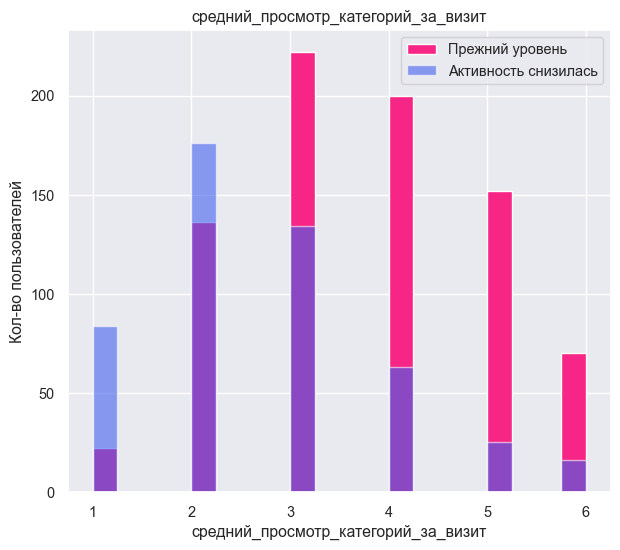

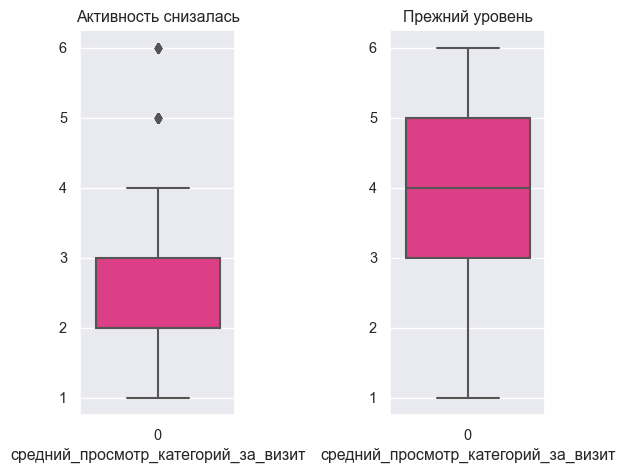

In [27]:
hist_comparsion(inactive_users, active_users, 
                'средний_просмотр_категорий_за_визит', 20)
box_comparsion(inactive_users, active_users, 
               'средний_просмотр_категорий_за_визит')

Пользователи со сниженной активностью в среднем смотрят меньше категорий за визит: 2-3 против 4 у пользователей с прежним уровнем активности.

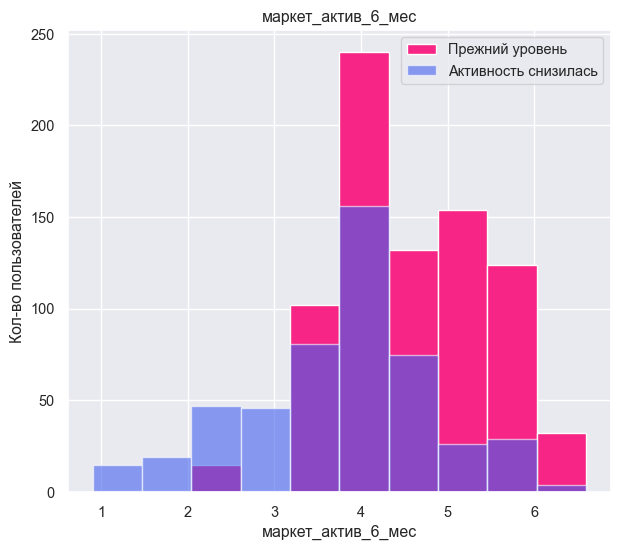

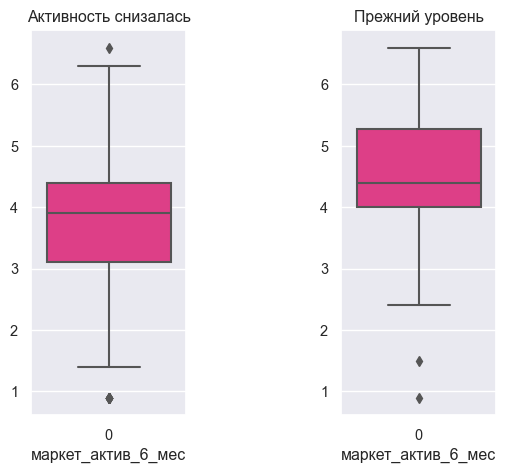

In [28]:
hist_comparsion(inactive_users, active_users, 'маркет_актив_6_мес', 10)
box_comparsion(inactive_users, active_users, 'маркет_актив_6_мес')

У пользователей со сниженной активностью среднемесячное значение маркетинговых коммуникаций компании за последние 6 месяцев меньше, чем у пользователей с прежним уровнем активности.

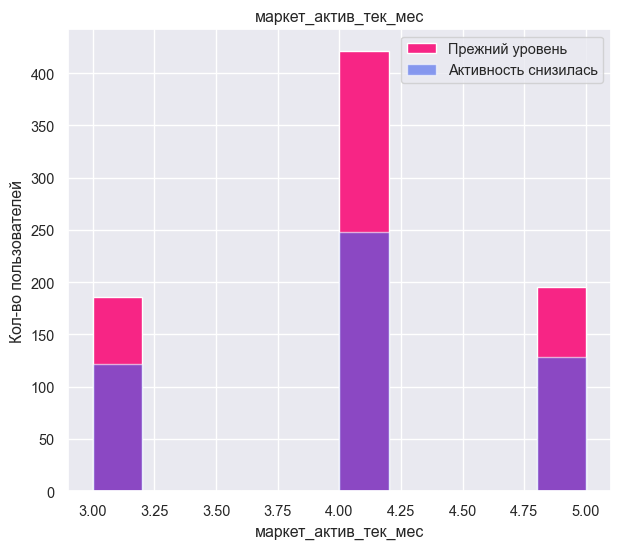

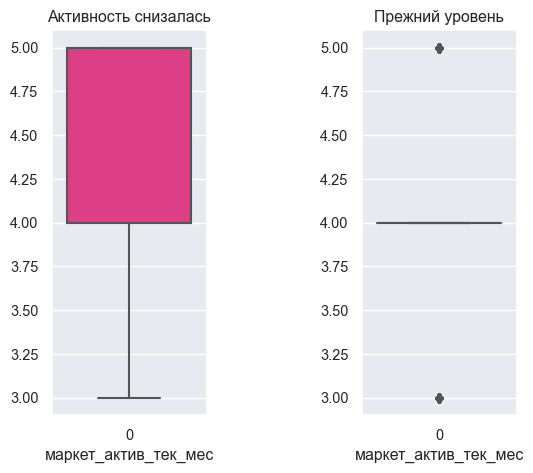

In [29]:
hist_comparsion(inactive_users, active_users, 'маркет_актив_тек_мес', 10)
box_comparsion(inactive_users, active_users, 'маркет_актив_тек_мес')

Диаграмма размаха выглядит так, потому что значений у признака всего три. Количество маркетинговых коммуникаций в текущем месяце у обоих категорий пользователей примерно одинакова (в среднем составляет 4).

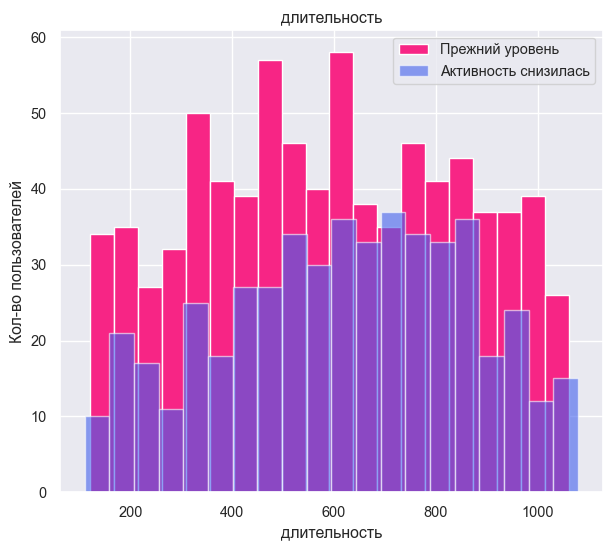

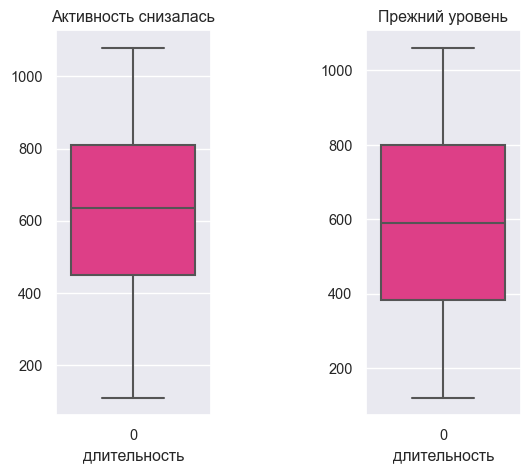

In [30]:
hist_comparsion(inactive_users, active_users, 'длительность',20)
box_comparsion(inactive_users, active_users, 'длительность')

Большинство пользователей с прежним уровнем активности зарегистрировались 600 дней назад (примерно полтора года). Большинство пользователей со сниженным уровнем активности зарегистрировались  650-700 дней назад (почти два года).

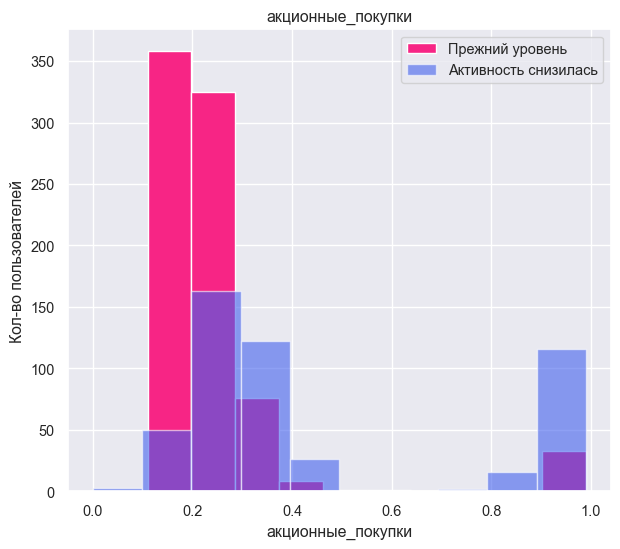

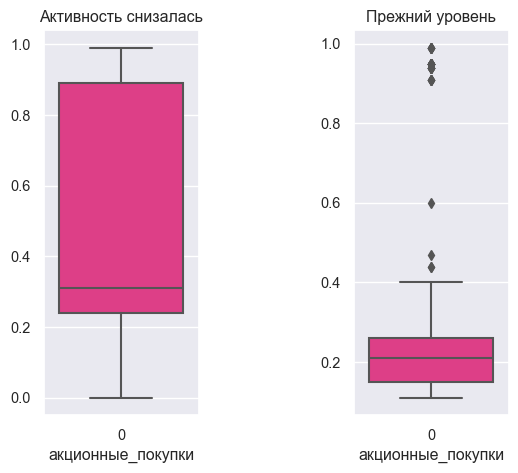

In [31]:
hist_comparsion(inactive_users, active_users, 'акционные_покупки', 10)
box_comparsion(inactive_users, active_users, 'акционные_покупки')

На графике виден выброс. Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев, равная 1 чаще встречается среди пользователей со сниженной активностью.

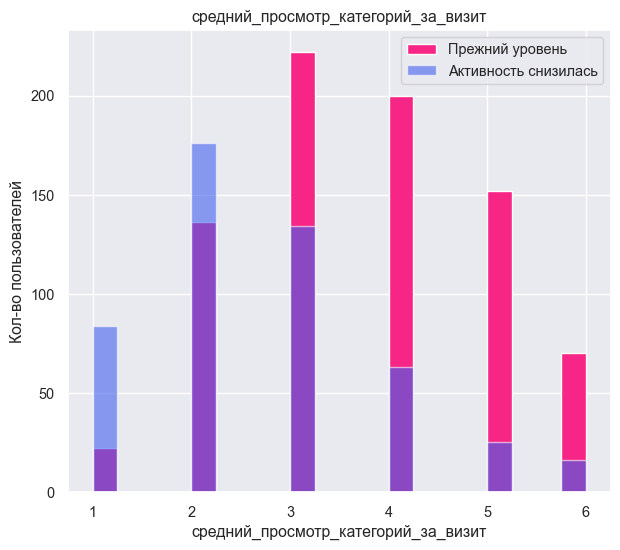

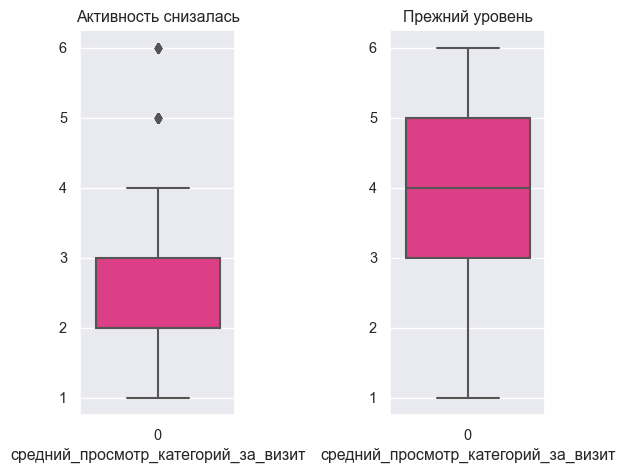

In [32]:
hist_comparsion(inactive_users, active_users, 
                'средний_просмотр_категорий_за_визит', 20)
box_comparsion(inactive_users, active_users, 
               'средний_просмотр_категорий_за_визит')

В среднем покупатели со сниженной активностью смотрят меньше категорий за визит, чем пользователи с прежним уровнем активности.

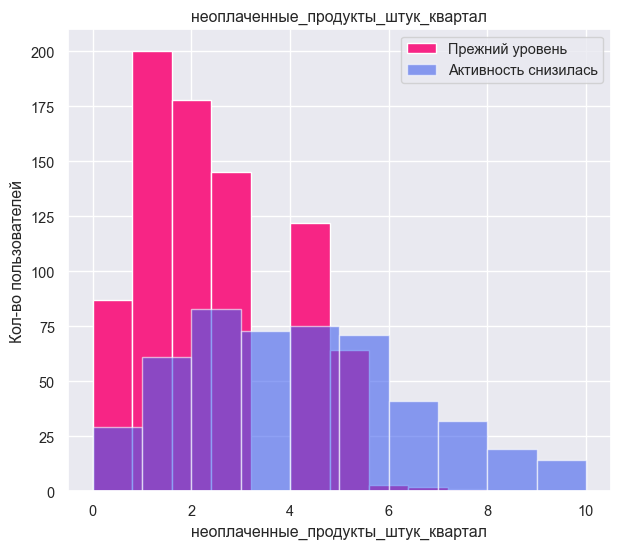

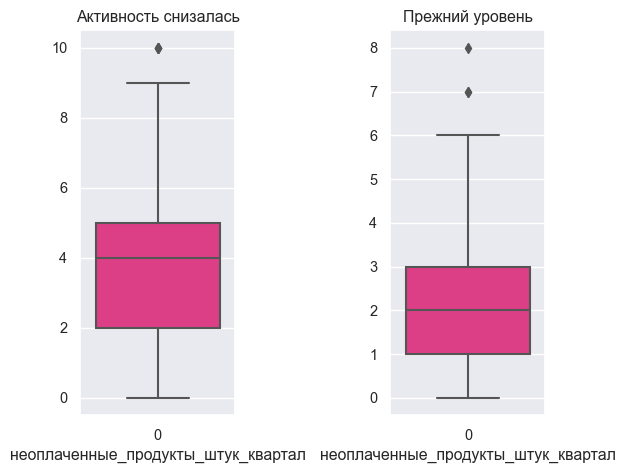

In [33]:
hist_comparsion(inactive_users, active_users, 
                'неоплаченные_продукты_штук_квартал', 10)
box_comparsion(inactive_users, active_users, 
               'неоплаченные_продукты_штук_квартал')

У покупателей со сниженной активностью общее число неоплаченных товаров в корзине за последние 3 месяца больше, чем у пользователей с прежним уровнем активности.

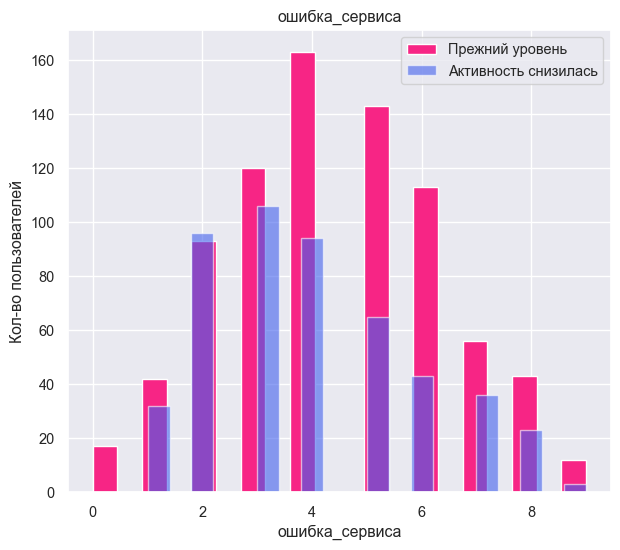

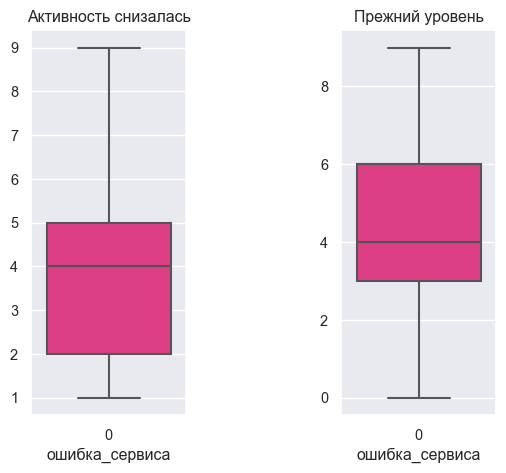

In [34]:
hist_comparsion(inactive_users, active_users, 'ошибка_сервиса', 20)
box_comparsion(inactive_users, active_users, 'ошибка_сервиса')

Число сбоев, коснувшихся покупателей обеих категорий во время посещения сайта примерно одинаково.

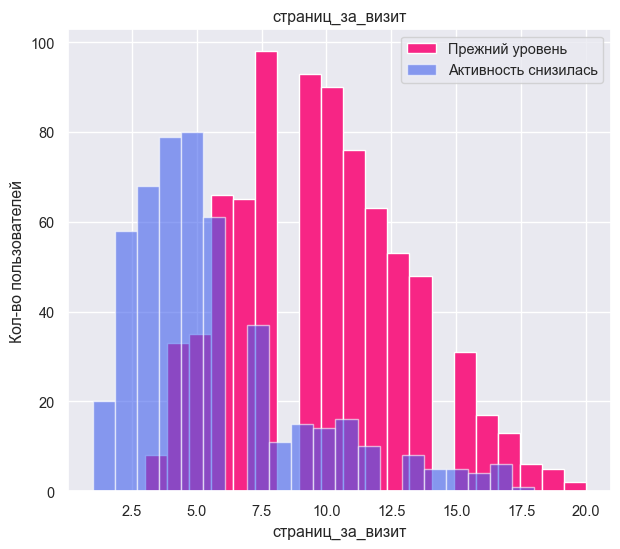

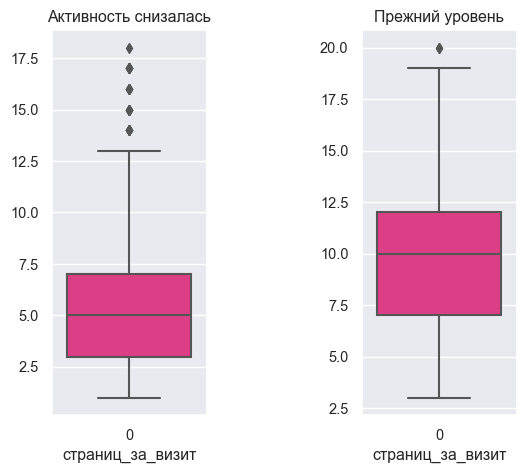

In [35]:
hist_comparsion(inactive_users, active_users, 'страниц_за_визит', 20)
box_comparsion(inactive_users, active_users, 'страниц_за_визит')

Среднее количество страниц, просмотренных покупателями со сниженной активностью за один визит на сайт за последние 3 месяца, значительно меньше чем у пользователей с прежней активностью.

**Вывод:** В столбце `маркет_актив_тек_мес` уникальных значений всего 3, поэтому графики так выглядят. 

Выбросы в признаках `маркет_актив_6_мес`, `акционные_покупки` и `неоплаченные_продукты_штук_квартал` удалять не надо, тк. эти значения не являются невозможными аномалиями, хоть и встречаться довольно редко.

Проверим распределение категориальных признаков.

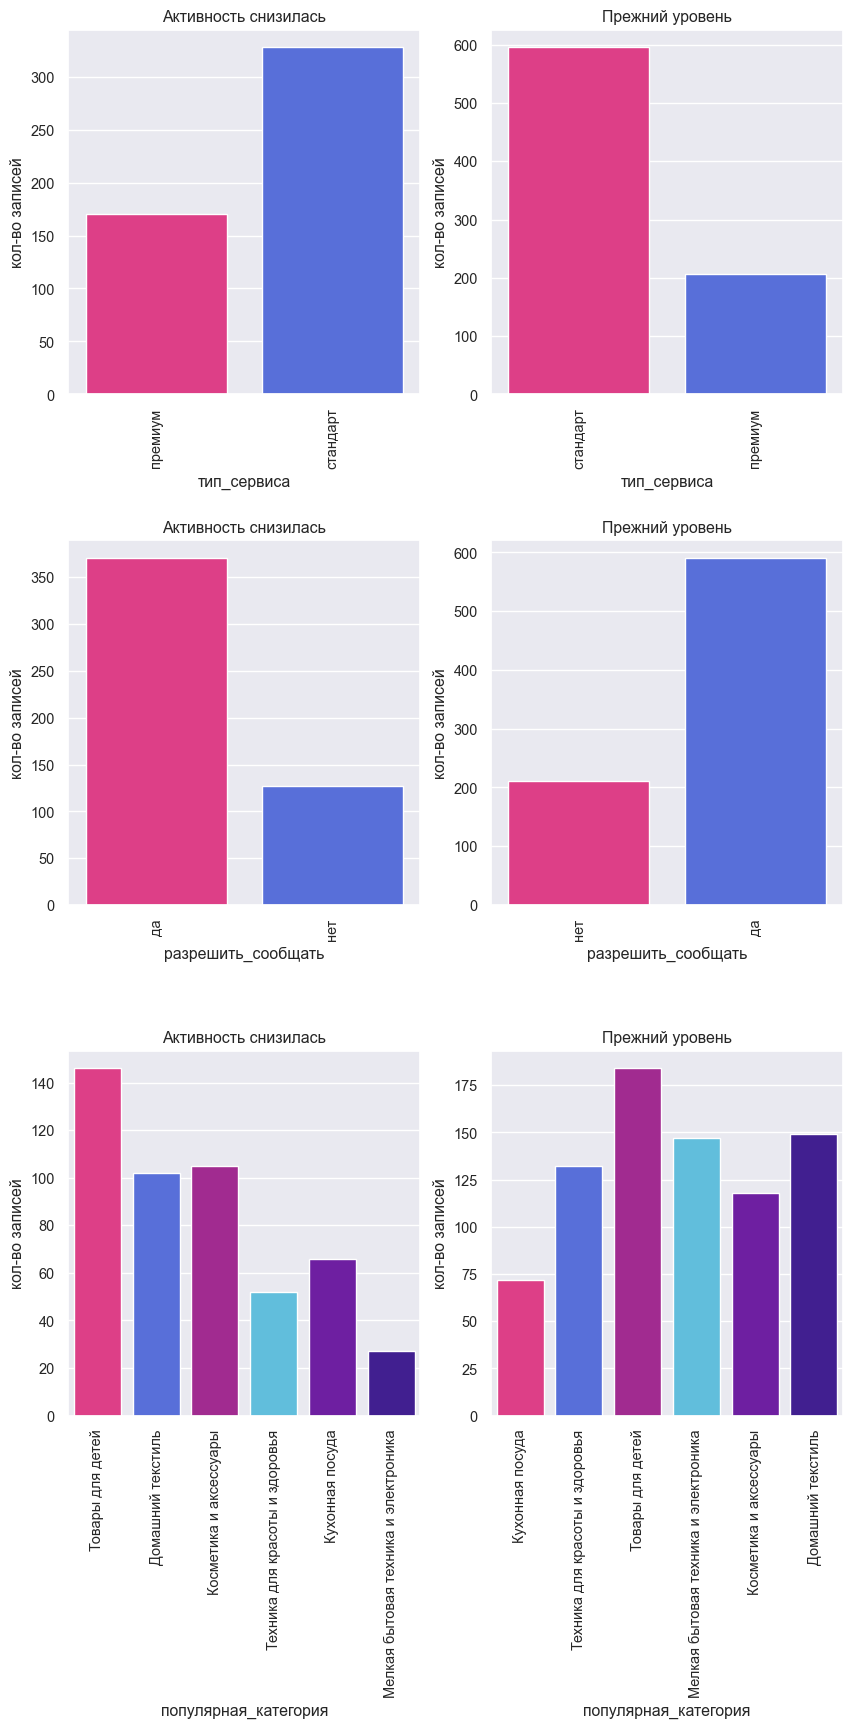

In [36]:
catplot_cmprsn(inactive_users, active_users)

Среди покупателей со сниженной активностью доля клиентов с типом сервиса "премиум" чуть больше, чем у покупателей с прежней активностью.

Доля покупателей с согласием на дополнительные предложения о товаре не меняется от типа активности.

**Самой популярной категорией** у покупателей являются "Товары для детей", также достаточно популярным является "Домашний текстиль". **Далее категории среди пользователей со сниженным и преждним уровнем активности меняются:** среди сниженной активности **наименее** популярные категории - "Мелкая бытовая техника и эликтроника" и "Техника для красоты и здоровья", а вот пользователи с прежним уровнем активности достаточно заинтересованы этими категориями. И наоборот - покупателям со сниженной активностью **интересны** категории "Косметика и аксессуары" и "Кухонная посуда", а среди покупателей с прежним уровнем активности данные категории наименее популярны.

**Общий вывод:**

Среднестатистический покупатель интернет-магазина **с прежним уровнем активности** имеет следующие значения признаков:
- `тип_сервиса` - **стандарт**;
- `разрешить_сообщать` дополнительные предложения о товаре - **да**;
- `маркет_актив_6_мес`: среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев равно **4.4**;
- `маркет_актив_тек_мес`: количество маркетинговых коммуникаций в текущем месяце - **4**;
- `длительность` (кол-во дней) с момента регистрации покупателя на сайте - **600**;
- `акционные_покупки`: среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев составляет **0.2**;
- `популярная_категория` - **Товары для детей,** наименее популярная - **Кухонная посуда**;
- `средний_просмотр_категорий_за_визит`: среднее кол-во категорий, просмотренных пользователем за визит в течение последнего месяца, равно **3-4**;
- `неоплаченные_продукты_штук_квартал`: общее число неоплаченных товаров в корзине за последние 3 месяца - **2**;
- `ошибка_сервиса` коснулась покупателя **4** раза;
- `страниц_за_визит`: среднее количество страниц, просмотренных покупателем за один визит на сайт за последние 3 месяца, равно **10**.

Среднестатистический покупатель интернет-магазина **со сниженным уровнем активности** имеет следующие значения признаков:
- `тип_сервиса` - **стандарт**;
- `разрешить_сообщать` дополнительные предложения о товаре - **да**;
- `маркет_актив_6_мес`: среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев равно **3.9**;
- `маркет_актив_тек_мес`: количество маркетинговых коммуникаций в текущем месяце - **4**;
- `длительность` (кол-во дней) с момента регистрации покупателя на сайте - **650**;
- `акционные_покупки`: среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев составляет **0.3**;
- `популярная_категория` - **Товары для детей,** наименее популярная - **Мелкая бытовая техника и электроника**;
- `средний_просмотр_категорий_за_визит`: среднее кол-во категорий, просмотренных пользователем за визит в течение последнего месяца, равно **2**;
- `неоплаченные_продукты_штук_квартал`: общее число неоплаченных товаров в корзине за последние 3 месяца - **4**;
- `ошибка_сервиса` коснулась покупателя **4** раза;
- `страниц_за_визит`: среднее количество страниц, просмотренных покупателем за один визит на сайт за последние 3 месяца, равно **5**.

<a id='res_ur'></a>
### Исследовательский анализ `user_revenue`

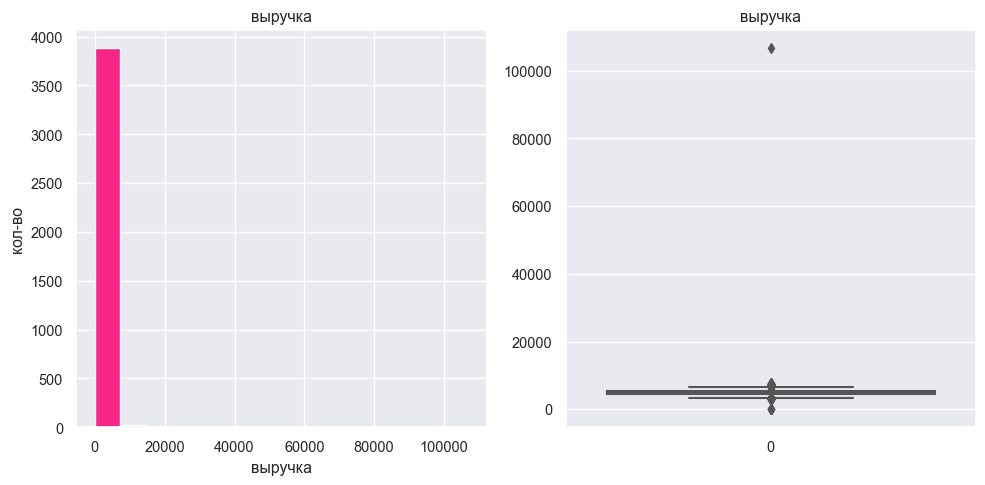

In [37]:
get_hist_box(user_revenue)

Посмотрим на аномальное значение.

In [38]:
user_revenue.sort_values(by='выручка', ascending=False).head(5)

,период,выручка
id,,
215380,текущий_месяц,106862.2
215493,текущий_месяц,7799.4
215435,текущий_месяц,7605.3
215841,текущий_месяц,7557.0
216144,текущий_месяц,7547.8


Слишком большая разница с остальными данными, возможно, это ошибка. Также за пределы "усов" графика входит значение 0. Избавимся от выбросов.

In [39]:
print('Процент выбросов от всего датафрейма составляет', '{:.2%}'.format(
    len(user_revenue[
        (user_revenue['выручка'] > 100000) \
        | (user_revenue['выручка'] == 0)]) / len(user_revenue))
     )

Процент выбросов от всего датафрейма составляет 0.18%


In [40]:
user_revenue = user_revenue[
    (user_revenue['выручка'] < 100000) & (user_revenue['выручка'] != 0)]
user_revenue['выручка'].describe()

count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64

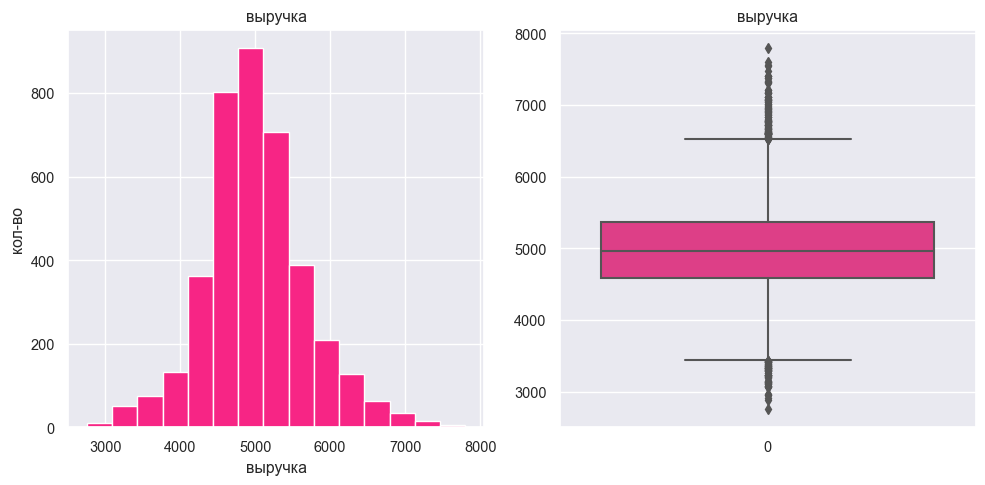

In [41]:
get_hist_box(user_revenue)

Теперь график выручки имеет нормальное распределие. Среднее и медианное значения близки друг к другу - 5007.28 и 4959.00.

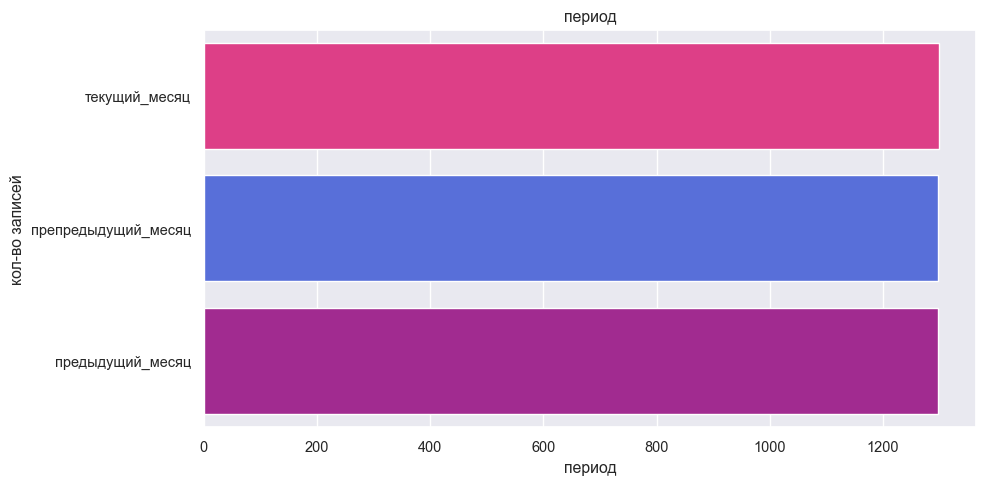

In [42]:
get_catplot(user_revenue)

Распределение по периодам выручки равномерное. 

<a id='res_ut'></a>
### Исследовательский анализ `user_time`

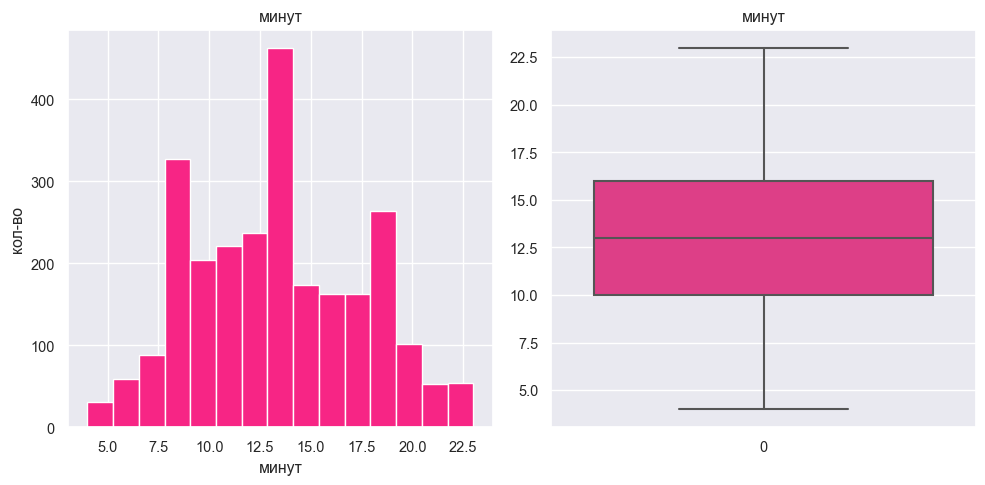

In [43]:
get_hist_box(user_time)

In [44]:
user_time['минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

Выбросов нет, распределение нормальное, среднее и медианное близки по значениям - 13.34 и 13.00.

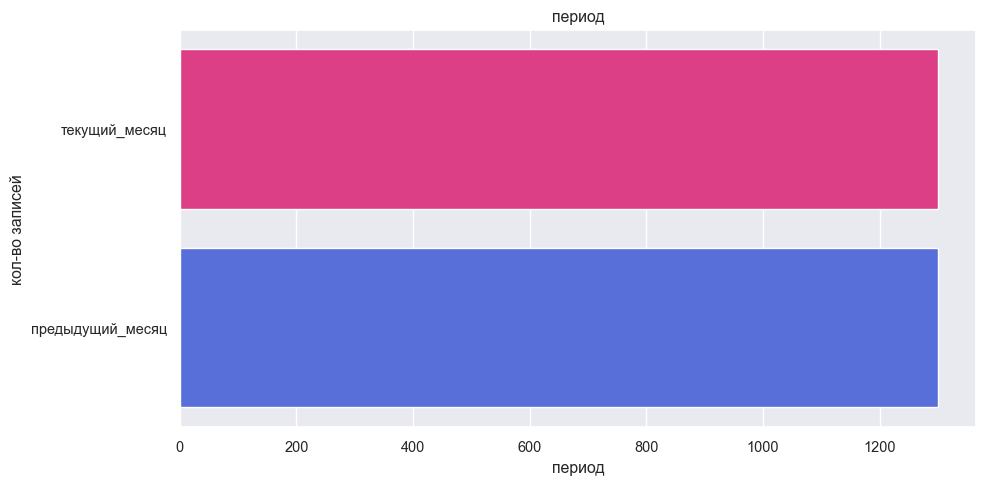

In [45]:
get_catplot(user_time)

Распределение по периодам равномерное.

<a id='res_pr'></a>
### Исследовательский анализ `profit`

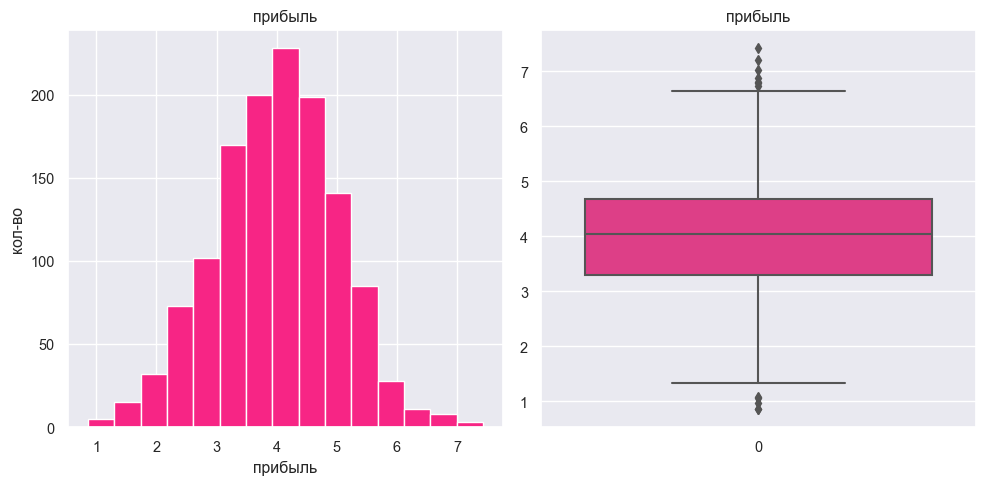

In [46]:
get_hist_box(profit)

In [47]:
profit['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

Распределение нормальное, среднее и медианное близки по значениям - 4.00 и 4.05.

**Вывод:** в результате исследовательского анализа данных обнаружены и удалены аномальные значения. В данных присутствуют выбросы.

<a id='join'></a>
## Объединение таблиц

Проверяем кол-во строк в датафреймах (данные о прибыли пока не нужны, поэтому их не трогаем).

In [48]:
print('Кол-во записей в user_behavior:', user_behavior.shape[0])
print('Кол-во записей в user_revenue:', user_revenue.shape[0])
print('Кол-во записей в user_time:', user_time.shape[0])

Кол-во записей в user_behavior: 1300
Кол-во записей в user_revenue: 3893
Кол-во записей в user_time: 2600


В датафреймах `user_revenue` и `user_time` данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода.

In [49]:
new_user_revenue = pd.pivot_table(
    user_revenue, 
    index='id',
    values='выручка',
    columns='период'
)
print(new_user_revenue.isna().sum())
new_user_revenue.head(3)

период
предыдущий_месяц       3
препредыдущий_месяц    3
текущий_месяц          1
dtype: int64


период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,NaN,NaN,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4


In [50]:
# удаляем пропуски
new_user_revenue = new_user_revenue.dropna(axis=0)
new_user_revenue.isna().sum()

период
предыдущий_месяц       0
препредыдущий_месяц    0
текущий_месяц          0
dtype: int64

In [51]:
new_user_time = pd.pivot_table(
    user_time, 
    index='id',
    values='минут',
    columns='период'
)

print(new_user_time.isna().sum())
new_user_time.head(3)

период
предыдущий_месяц    0
текущий_месяц       0
dtype: int64


период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13


In [52]:
print('Кол-во записей в new_user_revenue:', new_user_revenue.shape[0])
print('Кол-во записей в new_user_time:', new_user_time.shape[0])

Кол-во записей в new_user_revenue: 1296
Кол-во записей в new_user_time: 1300


Объединяем все датафреймы в один.

In [53]:
# переименовываем столбцы перед объединением
new_user_revenue.columns = [
    'выручка_предыдущий_месяц',
    'выручка_ПРЕпредыдущий_месяц',
    'выручка_текущий_месяц'
]

new_user_time.columns = [
    'минуты_предыдущий_месяц',
    'минуты_текущий_месяц'
]

users = user_behavior.merge(new_user_revenue, how='right', on='id')
users = users.merge(new_user_time, how='left', on='id')

users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

**Вывод:** таблицы успешно объединены.

<a id='corr'></a>
## Корреляционный анализ

Проведем корреляционный анализ признаков в количественной шкале в объединенном датафрейме.

In [54]:
num_colmns = users.select_dtypes(include=['number']).columns

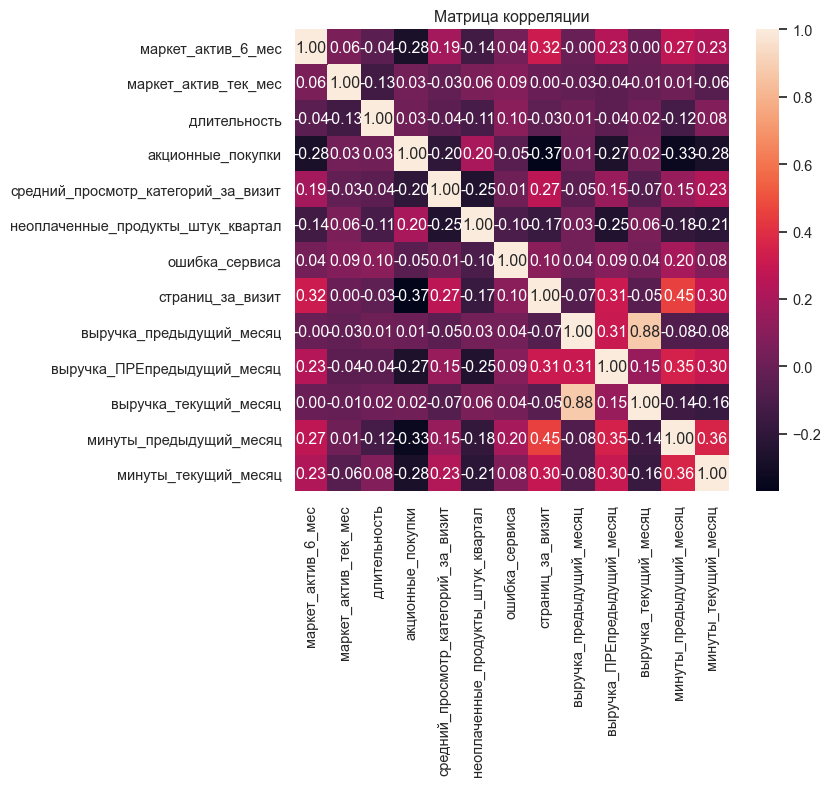

In [55]:
sns.heatmap(users[num_colmns].corr(method='spearman'), annot=True, fmt=".2f")

plt.title('Матрица корреляции');

**Вывод:** мультиколлинеарность - сильная линейная взаимосвязь между входными признаками. О ней говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. Таких коэффициентов в данной выборке нет, значит, **мультиколлинеарности нет.**

<a id='pipe'></a>
## Использование пайплайнов

Разбиваем данные на выборки.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
   users.drop(['покупательская_активность'], axis=1),
   users['покупательская_активность'],
   test_size = TEST_SIZE,
   random_state = RANDOM_STATE,
   stratify = users['покупательская_активность'])

Кодируем целевой признак - `покупательская_активность`.

In [57]:
# экземпляр класса LabelEncoder 
# для кодирования целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

Проверим какое значение досталось признакам.

In [58]:
label_encoder.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

- 0 - "Прежний уровень";
- 1 - "Снизилась".

Создаем списки с названиями признаков для дальнейшей обработки.

In [59]:
# признаки для OneHotEncoder
ohe_columns = ['разрешить_сообщать']
# признаки для OrdinalEncoder
ord_columns = ['тип_сервиса', 'популярная_категория']
# признаки для масштабирования
num_columns = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
    'акционные_покупки', 'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
    'страниц_за_визит', 'выручка_текущий_месяц',
    'выручка_предыдущий_месяц', 'выручка_ПРЕпредыдущий_месяц',
    'минуты_текущий_месяц', 'минуты_предыдущий_месяц'
]

ohe_columns, ord_columns, num_columns

(['разрешить_сообщать'],
 ['тип_сервиса', 'популярная_категория'],
 ['маркет_актив_6_мес',
  'маркет_актив_тек_мес',
  'длительность',
  'акционные_покупки',
  'средний_просмотр_категорий_за_визит',
  'неоплаченные_продукты_штук_квартал',
  'ошибка_сервиса',
  'страниц_за_визит',
  'выручка_текущий_месяц',
  'выручка_предыдущий_месяц',
  'выручка_ПРЕпредыдущий_месяц',
  'минуты_текущий_месяц',
  'минуты_предыдущий_месяц'])

Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование.

In [60]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
   [('simpleImputer_ohe', 
     SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
   ]
   )

Создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование.

In [61]:
# SimpleImputer + OE
ord_pipe = Pipeline(
   [('simpleImputer_before_ord', 
     SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord',  OrdinalEncoder( 
        categories=[
            ['премиум', 'стандарт'],
            ['Мелкая бытовая техника и электроника', 'Косметика и аксессуары',
             'Домашний текстиль', 'Товары для детей', 'Кухонная посуда',
             'Техника для красоты и здоровья'],
        ], 
        handle_unknown='use_encoded_value', unknown_value=np.nan)
       ),
    ('simpleImputer_after_ord', 
     SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
   ]
)

Создаём общий пайплайн для подготовки данных.

In [62]:
data_preprocessor = ColumnTransformer(
   [('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
   ],
   remainder='passthrough'
)

Создаём итоговый пайплайн с подготовкой данных и моделью.

In [63]:
pipe_final = Pipeline([
   ('preprocessor', data_preprocessor),
   ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Подготавливаем словари с гиперпараметрами для моделей.

In [64]:
param_grid = [
   # словарь для модели DecisionTreeClassifier()
   {
       'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
       'models__max_depth': range(2, 31),
       'models__max_features': range(2, 31),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
   },

   # словарь для модели KNeighborsClassifier()
   {
       'models': [KNeighborsClassifier()],
       'models__n_neighbors': range(2, 31),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
   },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

   # словарь для модели LogisticRegression()
   {
       'models': [LogisticRegression(
           random_state=RANDOM_STATE,
           solver='liblinear',
           penalty='l1'
       )],
       'models__C': [0.1, 1.0, 5.0, 10.0, 50.0],
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
   }
]

В качестве метрики выберем `ROC_AUC`, ее преимущества:
- она отлично подходит для бинарной классификации с несбалансированной выборкой.
- она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения. 

In [65]:
randomized_search = RandomizedSearchCV(
   pipe_final,
   param_grid,
   cv=5,
   scoring='roc_auc',
   random_state=RANDOM_STATE,
   n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Средняя метрика лучшей модели:', randomized_search.best_score_)

# проверяем работу модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                 

**Вывод:** создан один общий пайплайн для всех моделей и инструмент подбора гиперпараметров. Использована метрика `ROC-AUC`, так как она подходит для бинарной классификации и оценивает качество решений модели в общем виде, учитывая все возможные пороговые значения. 

- **Лучшая модель:** `KNeighborsClassifier` - метод k-ближайших соседей, с гиперпараметром `n_neighbors=7` (количество ближайших соседей, учитываемых для присвоения класса новым объектам), ее метрика равна `0.91` на тренировочных данных и `0.89` на тестовых.

<a id='shap'></a>
## Анализ важности признаков

In [66]:
# сохраняем в переменную best_model лучшую модель
best_model = randomized_search.best_estimator_\
.named_steps['models']

In [67]:
# подготавливаем данные
X_train_p = data_preprocessor.fit_transform(X_train)
X_train_p = pd\
.DataFrame(X_train_p, columns= ohe_columns + ord_columns + num_columns)

X_test_p = data_preprocessor.transform(X_test)
X_test_p = pd\
.DataFrame(X_test_p, columns= ohe_columns + ord_columns + num_columns)

COUNT = 200

In [68]:
# создаем сэмплы
X_train_smpl = shap.sample(X_train_p, COUNT, random_state=34)
X_test_smpl = shap.sample(X_test_p, COUNT, random_state=34)
# random_state не работает???

In [ ]:
explainer = shap.KernelExplainer(best_model.predict, X_train_smpl)
shap_values = explainer.shap_values(X_test_smpl)

Создаем графики важности признаков.

In [ ]:
shap.summary_plot(shap_values, X_test_smpl,
                      max_display=20, auto_size_plot=True)

In [ ]:
shap.summary_plot(shap_values, X_test_smpl, plot_type="bar")

**Общий вывод:**

Среднестатистический покупатель интернет-магазина **с прежним уровнем активности** имеет следующие значения признаков:
- `тип_сервиса` - **стандарт**;
- `разрешить_сообщать` дополнительные предложения о товаре - **да**;
- `маркет_актив_6_мес`: среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев равно **4.4**;
- `маркет_актив_тек_мес`: количество маркетинговых коммуникаций в текущем месяце - **4**;
- `длительность` (кол-во дней) с момента регистрации покупателя на сайте - **600**;
- `акционные_покупки`: среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев составляет **0.2**;
- `популярная_категория` - **Товары для детей,** наименее популярная - **Кухонная посуда**;
- `средний_просмотр_категорий_за_визит`: среднее кол-во категорий, просмотренных пользователем за визит в течение последнего месяца, равно **3-4**;
- `неоплаченные_продукты_штук_квартал`: общее число неоплаченных товаров в корзине за последние 3 месяца - **2**;
- `ошибка_сервиса` коснулась покупателя **4** раза;
- `страниц_за_визит`: среднее количество страниц, просмотренных покупателем за один визит на сайт за последние 3 месяца, равно **10**.

Среднестатистический покупатель интернет-магазина **со сниженным уровнем активности** имеет следующие значения признаков:
- `тип_сервиса` - **стандарт**;
- `разрешить_сообщать` дополнительные предложения о товаре - **да**;
- `маркет_актив_6_мес`: среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев равно **3.9**;
- `маркет_актив_тек_мес`: количество маркетинговых коммуникаций в текущем месяце - **4**;
- `длительность` (кол-во дней) с момента регистрации покупателя на сайте - **650**;
- `акционные_покупки`: среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев составляет **0.3**;
- `популярная_категория` - **Товары для детей,** наименее популярная - **Мелкая бытовая техника и электроника**;
- `средний_просмотр_категорий_за_визит`: среднее кол-во категорий, просмотренных пользователем за визит в течение последнего месяца, равно **2**;
- `неоплаченные_продукты_штук_квартал`: общее число неоплаченных товаров в корзине за последние 3 месяца - **4**;
- `ошибка_сервиса` коснулась покупателя **4** раза;
- `страниц_за_визит`: среднее количество страниц, просмотренных покупателем за один визит на сайт за последние 3 месяца, равно **5**.

**Вывод:** Целевой признак - `покупательская_активность` -  рассчитанный класс покупательской активности: «снизилась» (1) или «прежний уровень» (0).
- Малозначимые для модели признаки: 
    - `разрешить_сообщать` - согласие покупателя на дополнительные предложения о товаре;
    - `ошибка_сервиса` - число сбоев, которые коснулись покупателя во время посещения сайта;
    - данные за текущий месяц (выручка и проведенное на сайте время), скорее всего, неполные, поэтому к ним следует относиться с осторожностью.
- Сильнее всего на целевой признак влияют:
    - `популярная_категория` - самая популярная категория товаров у покупателя за последние 6 месяцев;
    - `тип_сервиса` - уровень сервиса, например «премиум» и «стандарт»;
    - `длительность` - сколько дней прошло с момента регистрации покупателя на сайте;
    - `маркет_актив_6_мес` - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев;
    - `выручка_предыдущий_месяц` - сумма выручки с покупателя за пердыдущий месяц.
    
При моделировании и принятии бизнес-решений **следует учитывать** популярную категорию пользователя и его тип сервиса, обращать внимание на кол-во неоплаченных позиций в корзине за квартал, проведенное пользователем время на сайте и сколько времени прошло с момента регистрации пользователя на сайте. Возможно, было бы полезно поработать над рекомендациями пользователям и над новыми предложениями, чем быстрее клиент находит то, что ему нужно, тем меньше шанс снижения активности.

**Анализ важности признаков подтверждает выводы, полученные в результате исследовательского анализа.**

Из дополнений и противоречий:
- Чем дольше пользователи пользуются сайтом, тем выше вероятность наткнуться на сбой. Но данный признак не влияет на целевой. 
- Покупатели с типом сервиса "Премимум" не так склоны к снижению активности.

<a id='seg'></a>
## Сегментация покупателей

Используем результаты моделирования и данные о прибыльности покупателей.

In [70]:
# применяем модель на всех данных
X = users.drop(['покупательская_активность'], axis=1)
y = users['покупательская_активность']
full_df = users

best_model = randomized_search.best_estimator_
predictions = best_model.predict_proba(X)[:, 1]

Проверим какой порог лучше взять.

In [71]:
# рассчитаем значения FPR и TRP
fpr, tpr, threshold = roc_curve(y, predictions, pos_label='Снизилась')
print(threshold)

[2.         1.         0.85714286 0.71428571 0.57142857 0.42857143
 0.28571429 0.14285714 0.        ]


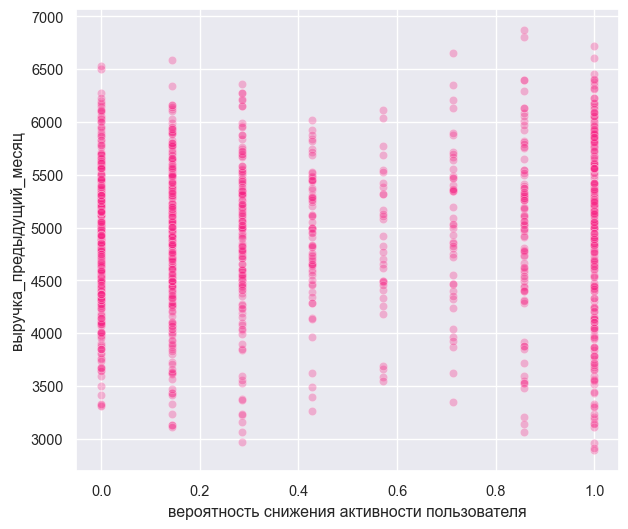

In [72]:
sns.scatterplot(
    x=predictions,
    y='выручка_предыдущий_месяц', 
    data=full_df,
    alpha=0.3
); 
plt.xlabel('вероятность снижения активности пользователя');

Выделим сегмент покупателей, активность которых снизилась.

In [73]:
# возьмем порог 0.7
prediction_flags = np.where(predictions > 0.7, True, False)
decreased_activity = full_df.loc[prediction_flags]
decreased_activity.tail()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_ПРЕпредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
id,,,,,,,,,,,,,,,,,
216598,Прежний уровень,стандарт,нет,3.5,3,841,0.95,Товары для детей,4,0,5,9,5265.5,5051.0,5581.4,11,13
216604,Прежний уровень,стандарт,да,4.9,5,350,0.99,Домашний текстиль,3,4,5,5,4545.0,4735.0,4840.1,14,14
216607,Прежний уровень,стандарт,да,3.3,4,575,0.23,Товары для детей,2,4,5,8,4991.0,4463.0,5578.6,11,12
216636,Прежний уровень,премиум,да,2.4,4,996,0.23,Кухонная посуда,3,4,5,6,5644.5,4860.0,6454.4,10,14
216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,4720.0,5183.0,4448.3,15,10


In [74]:
print('Кол-во записей в decreased_activity:', 
      decreased_activity.shape[0])
print('Кол-во записей в profit:', profit.shape[0])

Кол-во записей в decreased_activity: 379
Кол-во записей в profit: 1300


In [75]:
decreased_activity = decreased_activity.join(profit, on='id')
decreased_activity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 215349 to 216647
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            379 non-null    object 
 1   тип_сервиса                          379 non-null    object 
 2   разрешить_сообщать                   379 non-null    object 
 3   маркет_актив_6_мес                   379 non-null    float64
 4   маркет_актив_тек_мес                 379 non-null    int64  
 5   длительность                         379 non-null    int64  
 6   акционные_покупки                    379 non-null    float64
 7   популярная_категория                 379 non-null    object 
 8   средний_просмотр_категорий_за_визит  379 non-null    int64  
 9   неоплаченные_продукты_штук_квартал   379 non-null    int64  
 10  ошибка_сервиса                       379 non-null    int64  
 11  страниц_за_визит        

In [76]:
decreased_activity['прибыль'].describe()

count    379.000000
mean       4.006913
std        1.001261
min        1.060000
25%        3.310000
50%        4.060000
75%        4.650000
max        7.430000
Name: прибыль, dtype: float64

Проведем графическое и аналитическое исследование группы покупателей со сниженной активностью и большой среднемесячной прибылью (больше 4.5).

Судя по проведенному раннее анализу, рассматривать значения `ошибка_сервиса`, `разрешить_сообщать` не будем, - они не влияют на снижение активности пользователя. Так же не берем значения за текущий месяц, так как они не полные. Не имеет смысл смотреть на значения выручки с каждого пользователя, потому что мы рассматриваем более общее и важное для бизнеса значение - прибыль, которую получает магазин с пользователя.

Исследуем следующие признаки: `тип_сервиса`, `маркет_актив_6_мес`, `длительность`, `акционные_покупки`, `популярная_категория`, `средний_просмотр_категорий_за_визит`, `неоплаченные_продукты_штук_квартал`, `страниц_за_визит`, `минуты_предыдущий_месяц`.

In [77]:
decreased_activity = decreased_activity.query('прибыль > 4.5')

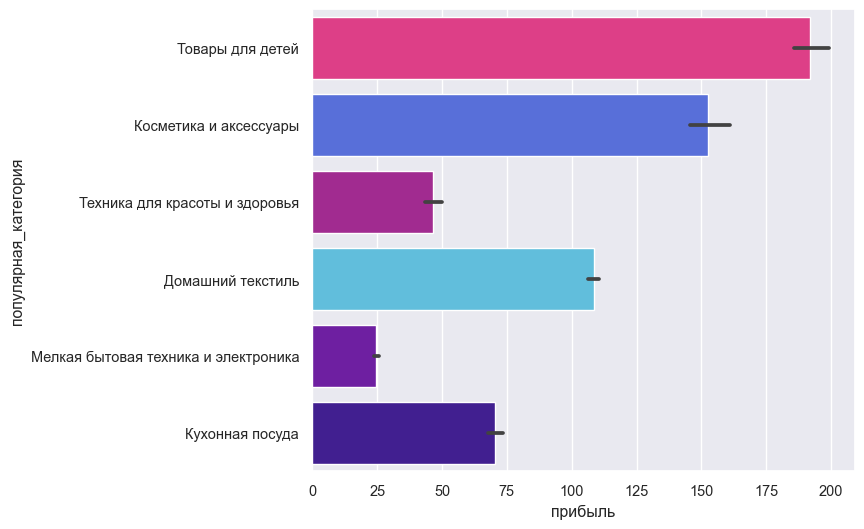

In [78]:
sns.barplot(
    data=decreased_activity,
    x='прибыль', 
    y='популярная_категория', 
    estimator=np.sum);

Среди покупателей со сниженной активностью и высокой прибылью наиболее прибыльными являются категории "Товары для детей", "Косметика и аксессуары" и "Домашний текстиль".

Техника и посуда - это товары длительного пользования. То, что данные категории редко появляются среди популярных, может означать, что у покупателей уже есть необходимый товар и что позиции из данных категорий его не интересуют. 

Проверим долю акционных покупок по категориям.

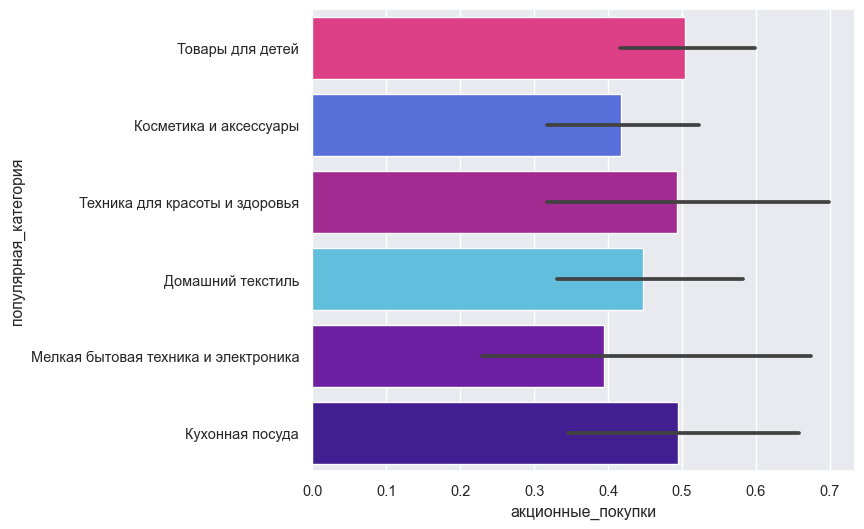

In [79]:
sns.barplot(data=decreased_activity, 
            x="акционные_покупки",
            y="популярная_категория", 
            estimator=np.mean);

Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев среди высокоприбыльных покупателей со сниженной активностью лидирует у категорий "Товары для детей", "Техника для красоты и здоровья" и "Кухонная посуда". Доли покупок на достаточно популярные категорит "Косметику и аксессуары" и "Домашний текстиль" ниже ожидаемого.

Посмотрим распределение сегмента по типу сервиса.

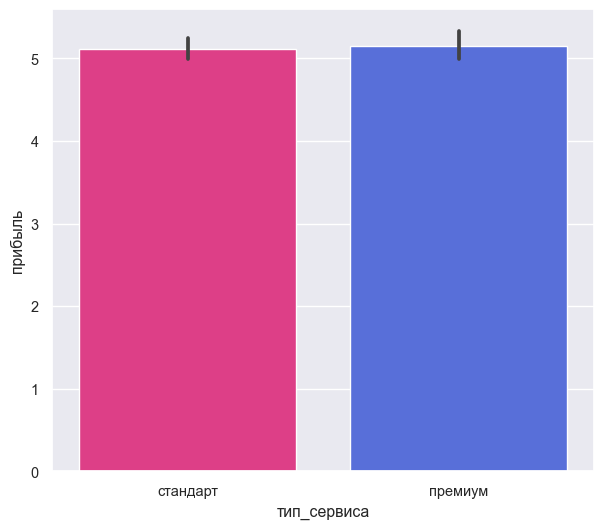

In [83]:
sns.barplot(
    data=decreased_activity,
    x='тип_сервиса', 
    y='прибыль', 
    estimator=np.mean);

Прибыль с обоих типов сервиса одинакова.

Проверим среднемесячное значение маркетинговых коммуникаций компании для популярных категорий сегмента за последние 6 месяцев.

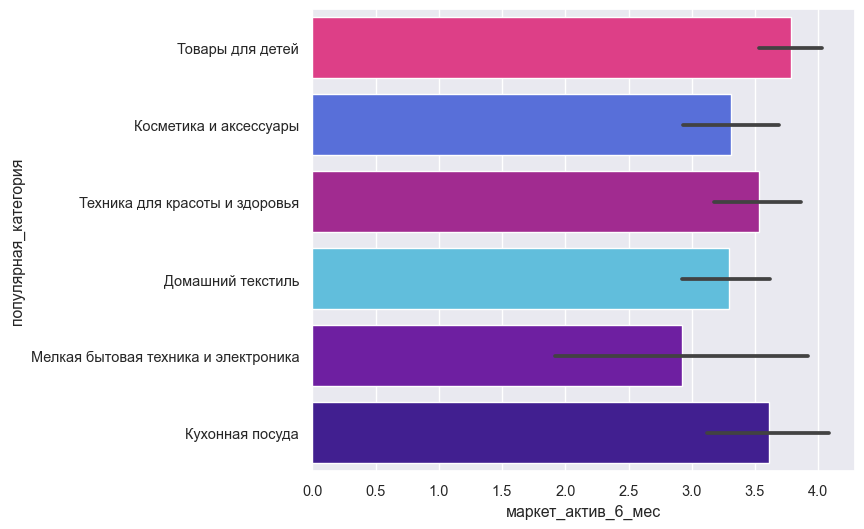

In [84]:
sns.barplot(data=decreased_activity, 
            x="маркет_актив_6_мес",
            y="популярная_категория", 
            estimator=np.mean);

Среднемесячная маркетинговая коммуникация для категории "Техника для красоты и здоровья" выше, чем среди более популярных категорий у высокоприбыльных клиентов со сниженной активностью - "Косметика и аксессуары" и "Домашний текстиль".

Сравним время с момента регистрации для высокоприбыльных покупателей с полученными ранее значениями.

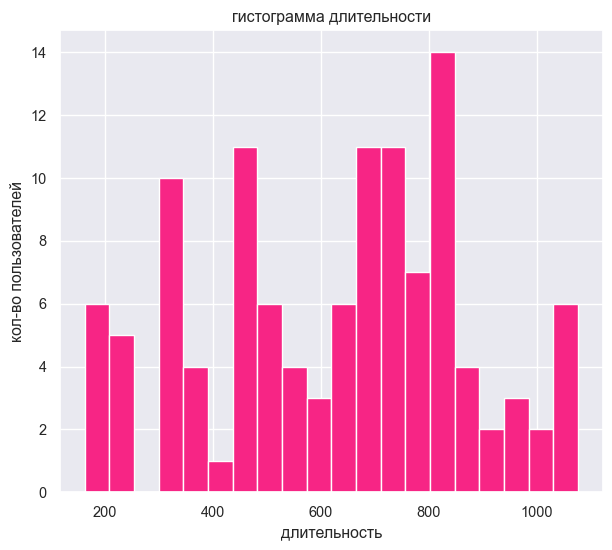

In [88]:
decreased_activity['длительность'].hist(bins=20)
plt.title('гистограмма длительности')
plt.ylabel('кол-во пользователей')
plt.xlabel('длительность')
plt.show();

Чаще всего снижение активности зафиксировано среди высокоприбыльных пользователей, зарегестрировавшихся около 800 дней назад (больше 2-х лет), что больше полученных ранее значений.

Посмотрим, в какой категории больше неоплаченных позиций за квартал.

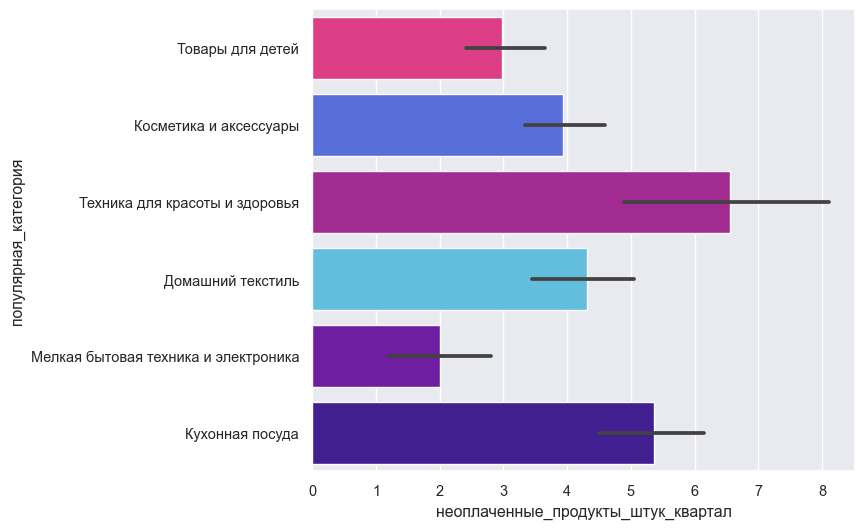

In [89]:
sns.barplot(data=decreased_activity, 
            x="неоплаченные_продукты_штук_квартал",
            y="популярная_категория", 
            estimator=np.mean);

В среднем общее число неоплаченных товаров в корзине за последние 3 месяца выделяется в категориях "Техника для красоты и здоровья" и "Кухонная посуда". В самой популярной категории "Товары для детей" - неоплаченных товаров обычно не так много. 

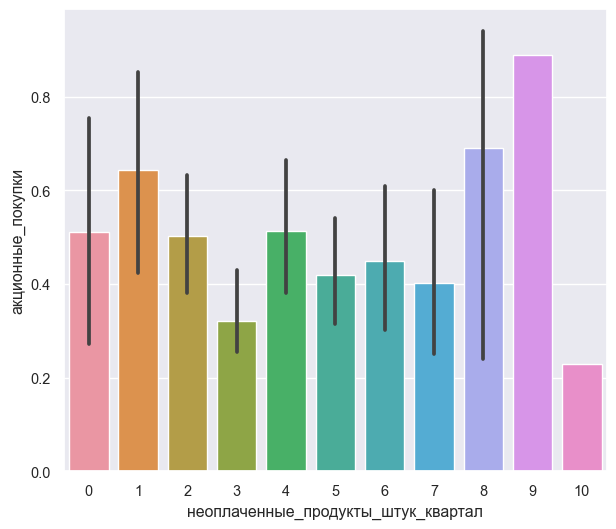

In [111]:
sns.barplot(data=decreased_activity, 
            x="неоплаченные_продукты_штук_квартал",
            y="акционные_покупки", 
            estimator=np.mean);

На графике есть выбросы. Есть неоплаченные позиции из-за отсутсвия акций, но при наличии акций так же есть приличное количество неоплаченных товаров - возможно, клиенты добавлют в корзину позиции на будущее (нашли во время акции, но хотят купить позже).

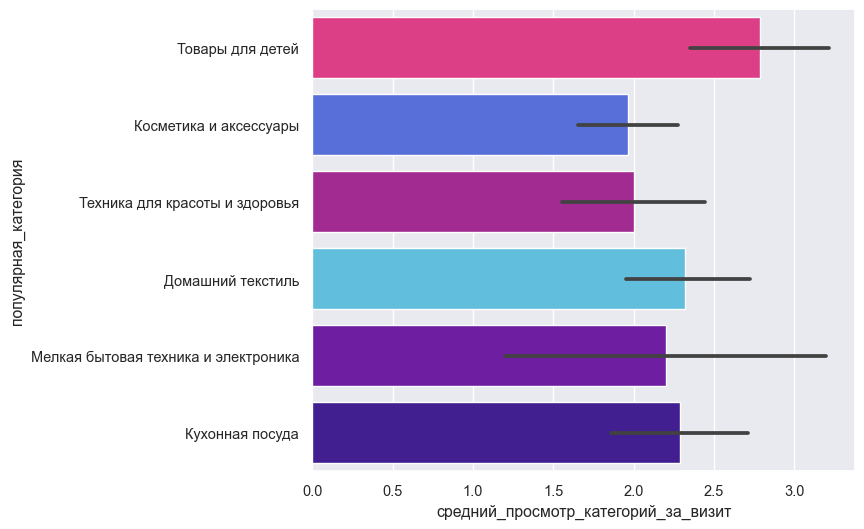

In [93]:
sns.barplot(data=decreased_activity, 
            x="средний_просмотр_категорий_за_визит",
            y="популярная_категория", 
            estimator=np.mean);

В течение последнего месяца среднее количество просмотренных категорий в общем равно 2, разброс небольшой, но чаще всего на другие категории обращают внимание пользователи с популярной категорией "Товары для детей".

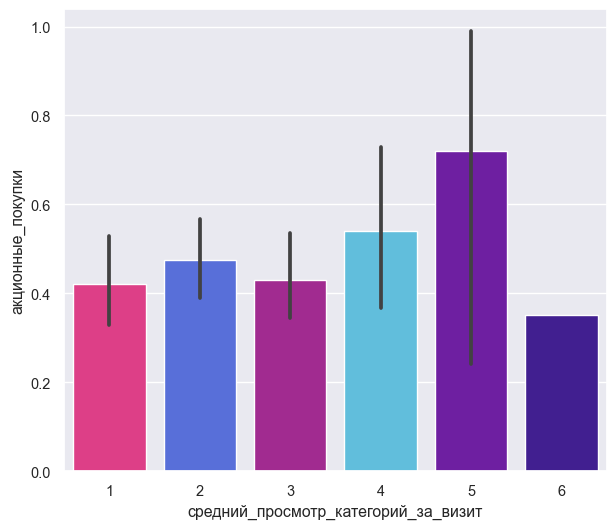

In [110]:
sns.barplot(data=decreased_activity, 
            x="средний_просмотр_категорий_за_визит",
            y="акционные_покупки", 
            estimator=np.mean);

Просмотр категорий за визит зависит от наличия акций. При этом все шесть категорий просматривают довольно редко даже во время акций, - скорее всего, потому что категория "Мелкая бытовая техника и электроника" наименее популярна (техника - это товар длительного пользования).

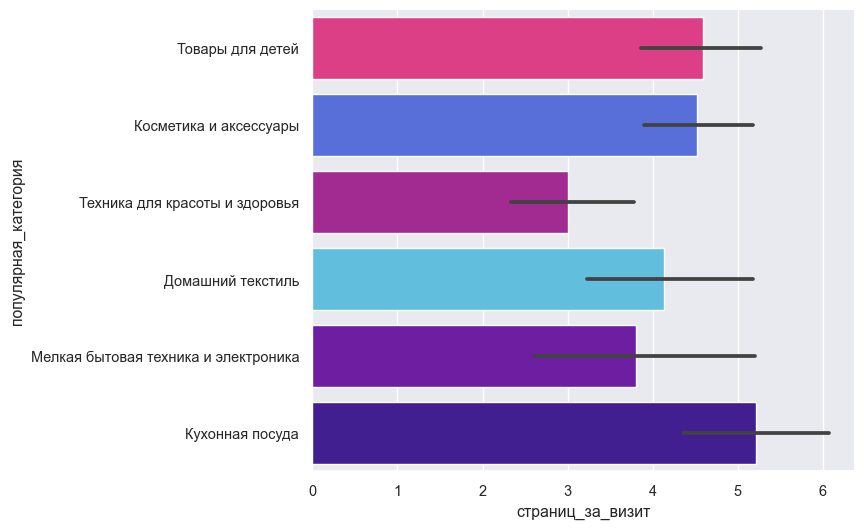

In [98]:
sns.barplot(data=decreased_activity, 
            x="страниц_за_визит",
            y="популярная_категория", 
            estimator=np.mean);

Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца - выделяется у пользователей с популярной категорией "Кухонная посуда", за ней следуют "Товары для детей" и "Косметика и аксессуары".

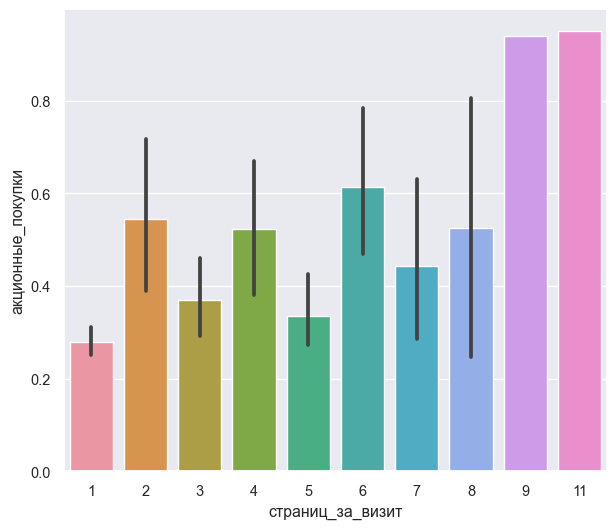

In [108]:
sns.barplot(data=decreased_activity, 
            x="страниц_за_визит",
            y="акционные_покупки", 
            estimator=np.mean);

Количество страниц, просмотренных за один визит покупателем, выростает в зависимости от наличия акций.

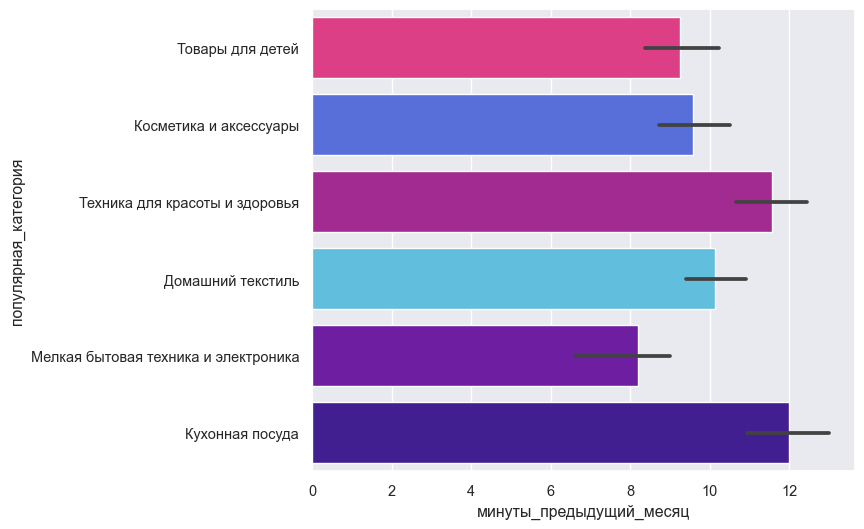

In [99]:
sns.barplot(data=decreased_activity, 
            x="минуты_предыдущий_месяц",
            y="популярная_категория", 
            estimator=np.mean);

Среднее значение времени, проведенного пользователями на сайте в прошлом месяце, больше всего у пользователей сегмента с популярными категориями "Кухонная посуда" и "Техника для красоты и здоровья". Меньше всего времени на сайте провели покупатели с популярными категориями "Мелкая бытовая техника и электроника" и "Товары для детей". 

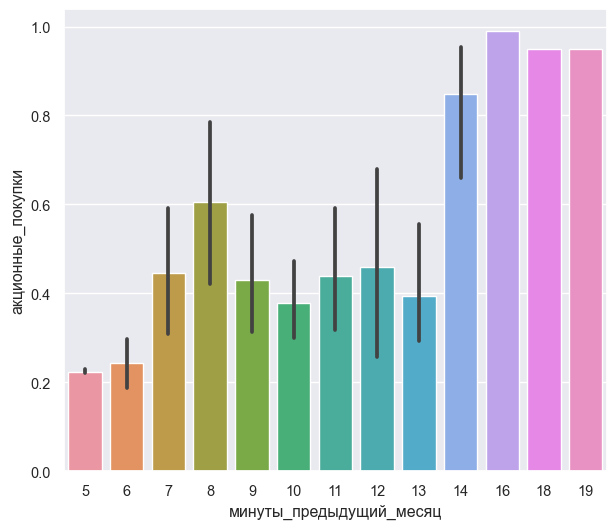

In [107]:
sns.barplot(data=decreased_activity, 
            x="минуты_предыдущий_месяц",
            y="акционные_покупки", 
            estimator=np.mean);

Чем выще среднемесячная доля покупок по акции от общего числа покупок, тем дольше времени на сайте проводят покупатели.

**Вывод:** была проведена сегментация покупателей, в ходе которой для дальнейшего анализа выбрана категория пользователей со сниженной активностью и высокой прибылью.

- **Предложения по работе с сегментом для увеличения покупательской активности следующие:**
    - Маркетинговые компании способствуют покупательской активности, но рассылки с дополнительной информацией о товаре практически не влияют на активность.
    
    - Среди покупателей со сниженной активностью и высокой прибылью наиболее прибыльными являются категории `Товары для детей`, `Косметика и аксессуары` и `Домашний текстиль`.
        - Техника и посуда - это товары длительного пользования. То, что данные категории редко появляются среди популярных, может означать, что у покупателей уже есть необходимый товар и что позиции из данных категорий его не интересуют. Значит, клиентам можно **предложить смежные товары и/или категории.**
        
    - Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев среди выбранного сегмента покупателей лидирует у категорий `Товары для детей`, `Техника для красоты и здоровья` и `Кухонная посуда`. Доли акционных покупок на достаточно популярные категорит `Косметику и аксессуары` и `Домашний текстиль` ниже ожидаемого. Скорее всего, это связано с тем, что среднемесячная маркетинговая коммуникация для категории `Техника для красоты и здоровья` выше, чем среди более популярных категорий - `Косметики и аксессуаров` и `Домашнего текстиля`.
        - Следует **увеличить количество маркетинговых коммуникаций компании в популярных категориях** (`Косметика и аксессуары` и `Домашний текстиль`).
        
    - Чаще всего на другие категории обращают внимание пользователи с популярной категорией `Товары для детей`. Среднее количество страниц, которые просмотрел покупатель за один визит на сайт выделяется у пользователей с популярной категорией `Кухонная посуда`, за ней следуют `Товары для детей` и `Косметика и аксессуары`. 
        - **От наличия акций зависит время, количество страниц и категорий, просмотренных покупателями.** То есть акции - это хороший способ показать разнообразие товаров и заинтересовать клиентов со сниженной активностью в дальнейших покупках.

<a id='fin'></a>
## Общие выводы

**Целью проекта определено следующее:**
- Построить модель, предсказывающую вероятность снижения покупательской активности клиента.
- Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

**Исходные данные:**
- Таблица `market_file.csv`, содержащая данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- Таблица `market_money.csv`, содержащая данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- Таблица `market_time.csv`, содержащая данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- Таблица `money.csv`, содержащая данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Для поиска лучшей модели проделаны следующие шаги:**
- В ходе предобработки данных изучены данные:
    - названия столбцов приведены к стандарту,
    - обработаны пропуски и дубликаты, 
    - исправлены орфографические ошибки в данных.
- В результате исследовательского анализа данных обнаружены и обработаны аномальные значения и выбросы.
- Таблицы `market_file.csv`, `market_money.csv` и `market_time.csv` объединены для увеличения признаков и улучшения качества будующей модели;
- Проведен корреляционный анализ признаков для проверки наличия мультиколлинеарности, которая мешает моделированию.
- Для автоматизации предобработки признаков использованы пайплайны.
- С помощью пайплайнов и автоматизированного поиска гипермараметров подобраны лучшие способы обработки, лучшие гиперпараметры и лучшая модель. Оценка производилась по метрике ROC-AUC, подходящей для бинарной классификации и оченивающей качество решений модели в общем виде, учитывая все возможные пороговые значения.

**Лучшая модель:** `KNeighborsClassifier(n_neighbors=7)`.

После подбора лучшей модели проведен **анализ важности признаков.**
- Малозначимыми признаками для предсказания снижения уровня активности покупателя являются: 
    - `разрешить_сообщать` - согласие покупателя на дополнительные предложения о товаре;
    - `ошибка_сервиса` - число сбоев, которые коснулись покупателя во время посещения сайта.
    - данные за текущий месяц (выручка и проведенное на сайте время), скорее всего, неполные, поэтому к ним следует относиться с осторожностью.
- Важными для предсказания цснижения уровня активности покупателя являются следующие признаки:
    - `популярная_категория` - самая популярная категория товаров у покупателя за последние 6 месяцев;
    - `тип_сервиса` - уровень сервиса, например «премиум» и «стандарт»;
    - `длительность` - сколько дней прошло с момента регистрации покупателя на сайте;
    - `маркет_актив_6_мес` - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев;
    - `выручка_предыдущий_месяц` - сумма выручки с покупателя за пердыдущий месяц.
    
ТО ЕСТЬ при моделировании и принятии бизнес-решений **следует учитывать** популярную категорию пользователя и его тип сервиса, обращать внимание на кол-во неоплаченных позиций в корзине за квартал, проведенное пользователем время на сайте и сколько времени прошло с момента регистрации пользователя на сайте.

Завершает исследование **сегментация покупателей**. Выбрана категория пользователей со сниженной активностью и высокой прибылью.

- **Предложения по работе с сегментом для увеличения покупательской активности следующие:**
    - Маркетинговые компании способствуют покупательской активности, но рассылки с дополнительной информацией о товаре практически не влияют на активность.
    
    - Среди покупателей со сниженной активностью и высокой прибылью наиболее прибыльными являются категории `Товары для детей`, `Косметика и аксессуары` и `Домашний текстиль`.
        - Техника и посуда - это товары длительного пользования. То, что данные категории редко появляются среди популярных, может означать, что у покупателей уже есть необходимый товар и что позиции из данных категорий его не интересуют. Значит, клиентам можно **предложить смежные товары и/или категории.**
        
    - Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев среди выбранного сегмента покупателей лидирует у категорий `Товары для детей`, `Техника для красоты и здоровья` и `Кухонная посуда`. Доли акционных покупок на достаточно популярные категорит `Косметику и аксессуары` и `Домашний текстиль` ниже ожидаемого. Скорее всего, это связано с тем, что среднемесячная маркетинговая коммуникация для категории `Техника для красоты и здоровья` выше, чем среди более популярных категорий - `Косметики и аксессуаров` и `Домашнего текстиля`.
        - Следует **увеличить количество маркетинговых коммуникаций компании в популярных категориях** (`Косметика и аксессуары` и `Домашний текстиль`).
        
    - Чаще всего на другие категории обращают внимание пользователи с популярной категорией `Товары для детей`. Среднее количество страниц, которые просмотрел покупатель за один визит на сайт выделяется у пользователей с популярной категорией `Кухонная посуда`, за ней следуют `Товары для детей` и `Косметика и аксессуары`. 
        - **От наличия акций зависит время, количество страниц и категорий, просмотренных покупателями.** То есть акции - это хороший способ показать разнообразие товаров и заинтересовать клиентов со сниженной активностью в дальнейших покупках.

[Наверх][1]

[1]:#task